# Superradiant-scattered light around a Kerr black hole

In [30]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from scipy.spatial import distance

In [2]:
def calculate_christoffel(jacob, g_inv, dims):
    # based on https://github.com/AndreaAntoniali/Riemann-tensor-calculator/blob/main/Riemann_Calculations.ipynb
    gamma = np.zeros((dims, dims, dims))
    for beta in range(dims):
        for mu in range(dims):
            for nu in range(dims):
                for alpha in range(dims):
                    gamma[beta,mu,nu] = 1/2 * g_inv[alpha][beta] * (jacob[alpha][mu][nu] + jacob[alpha][nu][mu] - jacob[mu][nu][alpha])
    return gamma

def christoffel_at_point_4d(metric, inverse_metric, t, r, theta, phi, dims):
    coord = torch.tensor([t, r, theta, phi], requires_grad=True)
    g_inv = inverse_metric(coord)
    jacobian = torch.autograd.functional.jacobian(metric, coord, create_graph=True)
    return calculate_christoffel(jacobian, g_inv, dims)

In [3]:
def kerr_metric(coords, M=1, a=0.97):
    t = coords[0]
    r = coords[1]
    theta = coords[2]
    phi = coords[3]
    sigma = r ** 2 + a ** 2 * torch.cos(theta) ** 2
    delta = r ** 2 - 2 * M * r + a ** 2
    return torch.tensor([
        [-(1 - (2 * M * r) /sigma), 0., 0., -((2 * M * r * a * torch.sin(theta) ** 2) / sigma)],
        [0., sigma / delta, 0., 0.],
        [0., 0., sigma, 0.],
        [-((2 * M * r * a * torch.sin(theta) ** 2) / sigma), 0., 0., (r ** 2 + a ** 2 + (2 * M * r * a ** 2)/sigma * torch.sin(theta) ** 2) * torch.sin(theta) ** 2]
    ])

def kerr_inverse_metric(coords, M=1, a=0.97):
    # Based off https://www.roma1.infn.it/teongrav/onde19_20/kerr.pdf
    t = coords[0]
    r = coords[1]
    theta = coords[2]
    phi = coords[3]
    sigma = r ** 2 + a ** 2 * torch.cos(theta) ** 2
    delta = r ** 2 - 2 * M * r + a ** 2
    return torch.tensor([
        [-1 / delta * (r ** 2 + a ** 2 + (2 * M * r * a ** 2) / sigma * torch.sin(theta) ** 2), 0., 0., -(2 * M * r * a) / (sigma * delta)],
        [0., delta / sigma, 0., 0.],
        [0., 0., 1 / sigma, 0.],
        [-(2 * M * r * a) / (sigma * delta), 0., 0., (delta - a ** 2 * torch.sin(theta) ** 2) / (sigma * delta * torch.sin(theta) ** 2)]
    ])

def kerr_d_dt(X, t):
    # Array of derivatives
    f = np.zeros(X.shape)
    x = X[:4]
    velocities = X[4:]
    f[:4] = velocities
    t, r, theta, phi = x
    Gamma = christoffel_at_point_4d(kerr_metric, kerr_inverse_metric, t, r, theta, phi, 4)

    for i in range(4):
        Gamma[:,:,i] += np.transpose(Gamma[:,:,i])
        Gamma[:,:,i] -= np.diag(np.diag(Gamma[:,:,i]))/2
        f[4 + i] = -velocities @ Gamma[:,:,i] @ velocities
    return f

In [4]:
def point_xyz_from_spherical(u):
    r = u[1]
    theta = u[2]
    phi = u[3]
    # Convert spherical to cartesian
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    point = [x, y, z]
    return point

In [5]:
def point_xyzt_from_spherical(u):
    t = u[0]
    r = u[1]
    theta = u[2]
    phi = u[3]
    # Convert spherical to cartesian
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    point = [t, x, y, z]
    return point

In [7]:
def kerr_intersection_rk4(mesh, f, u0, t0=0, tf=100000, h=0.00001, s_delta=0.1, debug=False):
    u = u0
    t = t0
    u_array = [u0]
    
    while t < tf:
        k1 = h * f(u, t)    
        k2 = h * f(u + 0.5 * k1, t + 0.5*h)
        k3 = h * f(u + 0.5 * k2, t + 0.5*h)
        k4 = h * f(u + k3, t + h)
        u = u + (k1 + 2*(k2 + k3 ) + k4) / 6
        u_array.append(u)
        point = point_xyz_from_spherical(u)
        if debug:
            print(point)
        if is_on_surface(mesh, np.array(point), s_delta):
            if debug:
                print("Found point on surface")
            return u_array, u

In [8]:
def txyz_to_spherical(t, arr):
    """
    Converts a [x, y, z] array
    to [r, theta, phi] array
    """
    x = arr[0]
    y = arr[1]
    z = arr[2]
    r = (x ** 2 + y ** 2 + z ** 2) ** (1/2)
    theta = np.arccos(z / r)
    phi = np.arctan(y / x)
    return [t, r, theta, phi]

In [9]:
def is_on_surface(mesh, point, delta=0.01):
    a = mesh.ray.contains_points([point - delta])
    b = mesh.ray.contains_points([point + delta])
    return a == True and b == False

The initial velocity is determined by the conversion of cartesian 3-velocity of light to spherical coordinates, resulting in:

$$
\frac{dr}{d\lambda} = c
$$

$$
\frac{d\theta}{d\lambda} = \theta_0
$$

$$
\frac{d\phi}{d\lambda} = \phi_0
$$

Conversions between spherical and cartesian velocities are given as follows - they are used to obtain a cartesian vector for use in the outgoing ray vector calculations:

$$
v_r = \frac{xx' + y y' + zz'}{r}
$$

$$
v_\theta = \frac{z r' - rz'}{r^2 \sqrt{1 - \left(\frac{z}{r}\right)^2}}
$$

$$
v_\phi = \frac{xy' - y x'}{x^2 + y^2}
$$

$$
v_x = r \cos \phi \cos \theta \theta' + \sin \theta \cos \phi r' - r \sin \phi \sin \theta \phi'
$$

$$
v_y = r \sin \phi \cos \theta \theta' + r \sin \theta \cos \phi \phi' + \sin \phi \sin \theta r'
$$

$$
v_z = \cos \theta r' - r \sin \theta \theta'
$$

In [10]:
def cartesian_velocity_to_spherical(x, y, z, v_x, v_y, v_z):
    r = (x ** 2 + y ** 2 + z ** 2) ** (1/2)
    v_r = (x * v_x + y * v_y + z * v_z) / r
    v_theta = (z * v_r - r * v_z) / (r ** 2 * (1 - (z / r) ** 2) ** (1/2))
    v_phi = (x * v_y - y * v_x) / (x ** 2 + y ** 2)
    return [v_r, v_theta, v_phi]

In [11]:
def spherical_velocity_to_cartesian(r, theta, phi, v_r, v_theta, v_phi):
    v_x = r * np.cos(phi) * np.cos(theta) * v_theta + np.sin(theta) + np.cos(phi) * v_r - r * np.sin(phi) * np.sin(theta) * v_phi
    v_y = r * np.sin(phi) * np.cos(theta) * v_theta + r * np.sin(theta) * np.cos(phi) * v_phi + np.sin(phi) * np.sin(theta) * v_r
    v_z = np.cos(theta) * v_r - r * np.sin(theta) * v_theta
    return [v_x, v_y, v_z]

In [12]:
# thanks to: https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points
def closest_vertex(point, mesh):
    closest_index = distance.cdist([point], mesh.vertices).argmin()
    return mesh.vertices[closest_index]

In [13]:
def get_normal_from_point(mesh, point):
    vertex = closest_vertex(point, mesh)
    vertices = mesh.vertices.tolist()
    idx = vertices.index(vertex.tolist())
    return mesh.vertex_normals[idx]

In [14]:
def norm(x): 
    return np.sqrt(x.dot(x))

def angle_between_vectors(v1, v2):
    return np.arccos((v1.dot(v2)) / (norm(v1) * norm(v2)))

In [15]:
def direction_from_angle(theta, normal):
    # counterclockwise rotation matrix
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta), np.cos(theta)]])
    return np.matmul(-normal, rotation_matrix)

In [16]:
def reflected_ray(incoming, normal):
    incoming_y = np.array([incoming[0], incoming[2]])
    incoming_x = np.array([incoming[1], incoming[2]])

    normal_y = np.array([normal[0], normal[2]])
    normal_x = np.array([normal[1], normal[2]])

    theta_y = angle_between_vectors(incoming_y, normal_y)
    theta_x = angle_between_vectors(incoming_x, normal_x)

    outgoing_y = direction_from_angle(theta_y, normal_y)
    outgoing_x = direction_from_angle(theta_x, normal_x)

    outgoing = np.array([outgoing_y[0], outgoing_x[0], outgoing_y[1]])
    return outgoing

In [17]:
# initial ray position
ray_origin = [0.01, 0.01, 0.8]
c = 3e8
theta_0 = np.pi
phi_0 = 0
ray_v = np.array([1.0, c, theta_0, phi_0])
# Initial condition uses ray origin converted to spherical coords
# and ray initial velocity
ray_origin_spherical = txyz_to_spherical(0.0, ray_origin)
ray_initial = np.concatenate((ray_origin_spherical, ray_v))

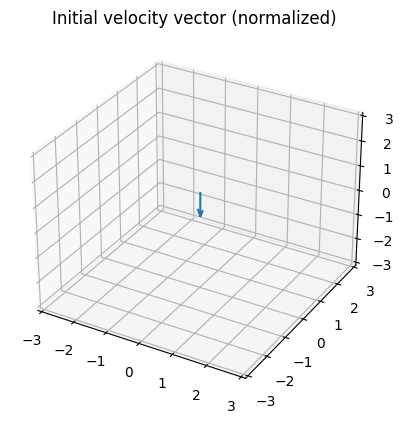

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(-3, 3)

v_x = np.sin(theta_0) * np.cos(phi_0)
v_y = np.sin(theta_0) * np.sin(phi_0)
v_z = np.cos(theta_0)

ax.quiver(*ray_origin, v_x, v_y, v_z)
plt.title("Initial velocity vector (normalized)")
plt.show()

In [19]:
N = 150 # 150 bounces

In [20]:
ray_positions_spherical = np.array((N + 1) * [ray_initial])

In [22]:
mesh = trimesh.load_mesh('geometry.stl')

In [37]:
path = [np.array([0, *ray_origin])]

In [38]:
for i in range(1, N):
    # Find the point of intersection accounting for curving
    # of straight path in Kerr spacetime
    geodesic, intersection_point = kerr_intersection_rk4(mesh, kerr_d_dt, ray_positions_spherical[i - 1], h=1e-12, debug=True)
    # Intersection point is next ray position
    # 4-vector of ray velocity is computed by doing vector calculations
    # based on last set of velocity vectors
    tau, r, theta, phi, v_tau, v_r, v_theta, v_phi = intersection_point
    position_cartesian = point_xyz_from_spherical(intersection_point)
    v_cartesian_incoming = spherical_velocity_to_cartesian(r, theta, phi, v_r, v_theta, v_phi)
    intersection_normal = get_normal_from_point(mesh, position_cartesian)
    v_cartesian_outgoing = reflected_ray(v_cartesian_incoming, intersection_normal)
    v_spherical_outgoing = cartesian_velocity_to_spherical(*position_cartesian, *v_cartesian_outgoing)
    # dr/dt = c, dtheta/dt and dphi/dt are computed from
    # reflected_ray() after conversion back to spherical
    next_starting_point = [tau, r, theta, phi, v_tau, c, v_spherical_outgoing[1], v_spherical_outgoing[2]]
    ray_positions_spherical[i] = next_starting_point
    for point in geodesic:
        path.append(point[:4]) # disregard velocity components

[0.010003749415978284, 0.010003749415978282, 0.800299953135939]
[0.010007498831957229, 0.010007498831957227, 0.800599906271878]
[0.010011248247937504, 0.010011248247937502, 0.8008998594078169]
[0.010014997663919115, 0.010014997663919114, 0.8011998125437558]
[0.010018747079902057, 0.010018747079902055, 0.8014997656796946]
[0.010022496495886333, 0.01002249649588633, 0.8017997188156335]
[0.01002624591187194, 0.01002624591187194, 0.8020996719515723]
[0.01002999532785888, 0.010029995327858879, 0.8023996250875111]
[0.010033744743847155, 0.010033744743847153, 0.8026995782234498]
[0.01003749415983676, 0.010037494159836758, 0.8029995313593885]
[0.010041243575827698, 0.010041243575827698, 0.8032994844953271]
[0.010044992991819969, 0.010044992991819967, 0.8035994376312657]
[0.010048742407813574, 0.010048742407813572, 0.8038993907672043]
[0.01005249182380851, 0.010052491823808508, 0.8041993439031428]
[0.010056241239804777, 0.010056241239804777, 0.8044992970390814]
[0.01005999065580238, 0.010059990

[0.010479925255966816, 0.010479925255966815, 0.8383940013999199]
[0.010483674672115006, 0.010483674672115004, 0.8386939545358546]
[0.010487424088264531, 0.01048742408826453, 0.8389939076717893]
[0.010491173504415391, 0.01049117350441539, 0.839293860807724]
[0.010494922920567579, 0.010494922920567577, 0.8395938139436586]
[0.010498672336721103, 0.010498672336721101, 0.8398937670795933]
[0.010502421752875957, 0.010502421752875956, 0.8401937202155277]
[0.010506171169032144, 0.010506171169032142, 0.8404936733514623]
[0.010509920585189665, 0.010509920585189663, 0.8407936264873968]
[0.01051367000134852, 0.010513670001348518, 0.8410935796233312]
[0.010517419417508703, 0.010517419417508701, 0.8413935327592656]
[0.010521168833670222, 0.01052116883367022, 0.8416934858952001]
[0.010524918249833074, 0.010524918249833072, 0.8419934390311344]
[0.010528667665997256, 0.010528667665997254, 0.8422933921670687]
[0.010532417082162774, 0.010532417082162772, 0.842593345303003]
[0.010536166498329622, 0.010536

Found point on surface
[0.01087361378836961, 0.010873613827247892, 0.8698890806766589]
Found point on surface
[0.010877363202098578, 0.010877363241555374, 0.8701890338126469]
Found point on surface
[0.010881112615827353, 0.010881112655862854, 0.870488986948635]
Found point on surface
[0.01088486202955593, 0.010884862070170333, 0.8707889400846228]
Found point on surface
[0.010888611443284313, 0.010888611484477811, 0.8710888932206109]
Found point on surface
[0.010892360857012498, 0.010892360898785286, 0.871388846356599]
Found point on surface
[0.010896110270740488, 0.010896110313092764, 0.8716887994925868]
Found point on surface
[0.010899859684468285, 0.010899859727400239, 0.8719887526285749]
Found point on surface
[0.010903609098195885, 0.010903609141707715, 0.8722887057645629]
Found point on surface
[0.010907358511923293, 0.01090735855601519, 0.8725886589005509]
Found point on surface
[0.0109111079256505, 0.010911107970322659, 0.8728886120365388]
Found point on surface
[0.0109148573393

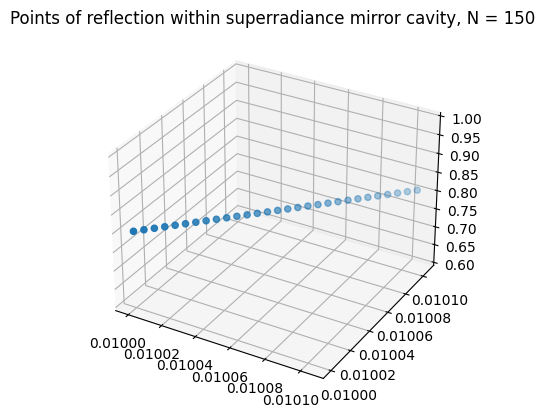

In [43]:
x_sol = np.array(path)

t = x_sol[:,0]
r = x_sol[:,1]
theta = x_sol[:,2]
phi = x_sol[:,3]

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

fig = plt.figure()
ax = plt.axes(projection="3d")

ax.set_zlim(0.6, 1)
ax.scatter(x[1:30], y[1:30], z[1:30]) # disregard first bounce as it is very far from the others
ax.set_title("Points of reflection within superradiance mirror cavity, N = 150")
plt.show()

Note that as the reflections after the first few bounces are extremely closely packed together, they are somewhat difficult to see in the above plot, but they are present.

The energy of the light ray can be found as follows:

$$
E = h \int_C \frac{Mrac}{\pi \Sigma^2} \cdot dr
$$

Where $a = 0.99$ and $\Sigma = r^2 + a^2 \cos \theta$.

In [44]:
E = []

In [45]:
M = 1.2e9
a = 0.99
h = 6.626e-34

In [46]:
for i in range(len(x_sol)):
    line_integral = 0
    j = 1
    while j < i:
        # numerically compute line integral
        r_derivative = (r[j + 1] - r[j - 1]) / (2 * (t[j + 1] - t[j]))
        theta_derivative = (theta[j + 1] - theta[j - 1]) / (2 * (t[j + 1] - t[j]))
        phi_derivative = (phi[j + 1] - phi[j - 1]) / (2 * (t[j + 1] - t[j]))
        ds = (r_derivative ** 2 + theta_derivative ** 2 + phi_derivative ** 2) ** (1/2)
        sigma = r[j] ** 2 + a ** 2 * np.cos(theta[j])
        frequency = (M * r[j] * a * c) / (np.pi * sigma ** 2)
        integrand = frequency * ds
        line_integral += integrand
        j += 1
    energy = line_integral * h
    E.append(energy)

/tmp/ipykernel_29843/723442059.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  r_derivative = (r[j + 1] - r[j - 1]) / (2 * (t[j + 1] - t[j]))
/tmp/ipykernel_29843/723442059.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  theta_derivative = (theta[j + 1] - theta[j - 1]) / (2 * (t[j + 1] - t[j]))
/tmp/ipykernel_29843/723442059.py:8: RuntimeWarning: invalid value encountered in double_scalars
  phi_derivative = (phi[j + 1] - phi[j - 1]) / (2 * (t[j + 1] - t[j]))
/tmp/ipykernel_29843/723442059.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  phi_derivative = (phi[j + 1] - phi[j - 1]) / (2 * (t[j + 1] - t[j]))


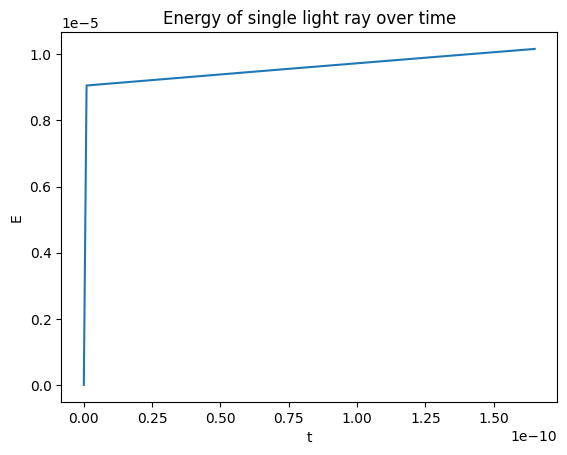

In [47]:
fig = plt.figure()
ax = plt.axes()

ax.plot(t, E)
ax.set_xlabel("t")
ax.set_ylabel("E")
plt.title("Energy of single light ray over time")
plt.show()